In [9]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/EE137/ecg_matlab
# just upload the data folder to your drive ** i wasn't able to access the shared with me folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1F6dOmt_qav0uuQ5vNcV-7Nyk2bMhTC9l/EE137/ecg_matlab


In [12]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pywt
from scipy.io import loadmat
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Conv2D, BatchNormalization, MaxPooling1D,MaxPooling2D, Dropout, Input,Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from skimage.transform import resize
import matplotlib.pyplot as plt

In [13]:
def downsample(original_data, sampling_rate = [2, 3, 4]):
  '''input: original data(timesteps x num of channel)(e.g. ecg5days data: 136 x 1)
     output: list of original signal and 3 downsampled signals based on the sampling rate  and list of signal lengths
  '''
  downsampled_data = [original_data]
  down_len = [original_data.shape[1]]
  for k in sampling_rate:
      n = original_data.shape[1]
      end_point = (n - 1) // k
      sampling_points = k * np.arange(end_point)
      downsampled_data.append(original_data[:, sampling_points])
      down_len.append(len(sampling_points))
  
  return downsampled_data, down_len

def moving_average(data, smoothing_factor = [2, 3, 4]):
  '''input: original data(timesteps x no of channel)(e.g. ecg5days data: 136 x 1)
     output: list of original signal and 3 downsampled signals based on the smoothing factor  and list of signal lengths
  '''
  movavg_data = list()
  movavg_len = list()
  for w in smoothing_factor:
      n, d = data.shape 
      output_len = d - w + 1
      movavg_len.append(output_len)
      output = np.zeros((n, output_len))
      for i in range(output_len):
          output[:,i] = np.mean(data[:, i : i + w], axis = 1)
      movavg_data.append(output)
  
  return movavg_data, movavg_len


'''
Function sliding_window_seg is used to segment data depending on window_size and stride,
If window_size == stride, then no overlap. 
'''
def sliding_window_seg(data, label, window_size, stride=1000):
    trunc_data = data
    print(trunc_data.shape)
    modulo = np.mod(trunc_data.shape[1]-window_size, stride)
    print(modulo)
    data_all = trunc_data[:,modulo:]
    row_num = int(((data_all.shape[1] - window_size)// stride + 1) * trunc_data.shape[0])
    num_chunk = int((data_all.shape[1] - window_size)// stride + 1)
    new_data = np.zeros((row_num, window_size))
    print(new_data.shape)
    new_label = np.zeros((row_num, label.shape[1]))
    print(new_label.shape)
    for i in range(data_all.shape[0]):
      for j in range(num_chunk):
        new_data[i * num_chunk + j] = data_all[i, j * window_size: (j + 1)* window_size]
        new_label[i * num_chunk + j] = label[i] 
    return new_data, new_label 

def create_cwt_image(X, n_scales = 64, rescale_size = 64, wavelet_name = "morl"):
  n_samples = X.shape[0]
  n_channels = 3
  scales = np.arange(1, n_scales + 1)
  X_cwt = np.ndarray(shape = (n_samples, rescale_size, rescale_size, n_channels), dtype = 'float32')
  for sample in range(n_samples):
      #print(sample)
      for signal in range(n_channels):
        serie = X[sample]
        coeffs, freq = pywt.cwt(serie, scales, wavelet_name)
        rescale_coeffs = resize(coeffs, (rescale_size, rescale_size), mode = 'constant')
        #print(rescale_coeffs, 'fdasfdsjfkhlaksjdfhakjlsdhflkasdhfkljadshkflj')
        X_cwt[sample, :,:, signal] = rescale_coeffs
  return X_cwt

In [14]:
'''
Function read_from_mat is for reading .mat file in numpy format, at the same time
class label is converted to one-hot encoding  
'''
def read_from_mat(data_file_name, label_file_name):
  data = loadmat(data_file_name, struct_as_record=False,squeeze_me=True)
  lb = loadmat(label_file_name)
  ecg_data = data['ECGData'].Data
  ecg_lb = np.squeeze(lb['label']) - 1
  # convert label to one-hot
  shape = (ecg_lb.size, ecg_lb.max() + 1)
  one_hot_lb = np.zeros(shape)
  rows = np.arange(ecg_lb.size)
  one_hot_lb[rows, ecg_lb] = 1
  return ecg_data, ecg_lb, one_hot_lb

In [15]:
ecg_data, _, ecg_label = read_from_mat('ECGData.mat', 'ecg_label.mat')

ecg_data_new, ecg_label_new = sliding_window_seg(ecg_data, ecg_label, 1000, stride=1000)
print(ecg_data_new.shape)
print(ecg_label_new.shape)

(162, 65536)
536
(10530, 1000)
(10530, 3)
(10530, 1000)
(10530, 3)


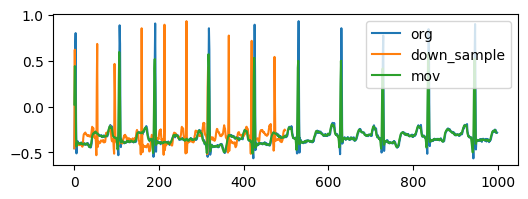

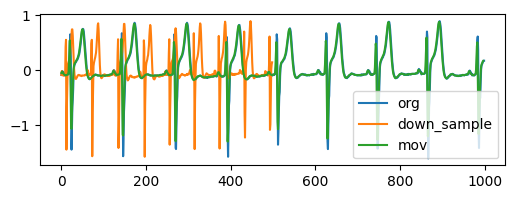

In [19]:
'''
Sanatity Check, if the data is sliced and read correctly? Please play with the index
For visulization
'''
import matplotlib.pyplot as plt
down_sample,  down_sample_len = downsample(ecg_data_new)
mov_avg, mov_avg_len = moving_average(ecg_data_new)
plt.figure(figsize=(6,2),dpi=100)
# type 1
plt.plot(ecg_data_new[0], label ='org')
plt.plot(down_sample[1][0],label ='down_sample')
plt.plot(mov_avg[1][0], label = 'mov')
plt.legend()
plt.show()
# type 2
plt.figure(figsize=(6,2),dpi=100)
plt.plot(ecg_data_new[10000], label ='org')
plt.plot(down_sample[1][10000],label ='down_sample')
plt.plot(mov_avg[1][10000], label = 'mov')
plt.legend()

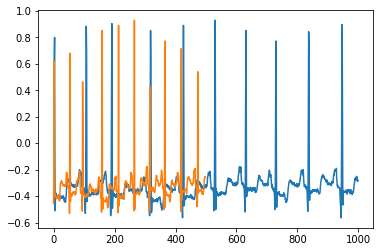

In [7]:
plt.plot(ecg_data_new[0], label ='org')
#plt.plot(mov_avg[1][0], label = 'mov')
plt.plot(down_sample[1][0],label ='down_sample')
#plt.legend()
plt.show()

In [8]:
'''
Number of training data is ratio * data.shape[0]
'''
def train_test_split(data, label, ratio):
    # shuffle train data
    perm = np.arange(data.shape[0])
    np.random.shuffle(perm)
    X = data[perm]
    y = label[perm]
    train_idx = int(data.shape[0] * ratio)
    X_train, X_test = X[:train_idx], X[train_idx:]
    y_train, y_test = y[:train_idx], y[train_idx:]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(ecg_data_new, ecg_label_new, 0.8)

In [9]:
X_train.shape

(8424, 1000)

In [10]:
'''
Generate input data that is compatable with our model, i.e.  downsampled data and 
moving average data
'''

def generate_dataset(data):
  downsampled_data, _ = downsample(data)
  movavg_data, _ = moving_average(data)
  cwt_data = create_cwt_image(data, n_scales = 64, rescale_size = 64)
  return [downsampled_data[0], downsampled_data[1], downsampled_data[2], downsampled_data[3],
            movavg_data[0], movavg_data[1], movavg_data[2], cwt_data]

X_train_final = generate_dataset(X_train)
X_test_final = generate_dataset(X_test)


In [11]:
# Check the shape
print(X_train_final[7].shape, X_test_final[7].shape)


(8424, 64, 64, 3) (2106, 64, 64, 3)


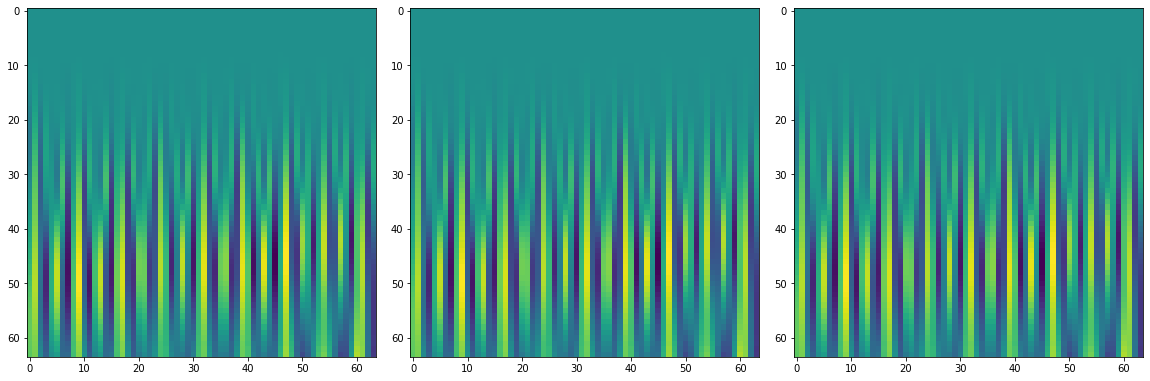

In [12]:
#plot cwt image
fig, axs = plt.subplots(1, 3, figsize=(20, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1, wspace=.1)
axs[0].imshow(X_train_final[7][0][:,:, 0]) # first channel of rgb
axs[1].imshow(X_train_final[7][0][:,:, 1]) # second channel of rgb
axs[2].imshow(X_train_final[7][0][:,:, 2]) # third channel of rgb

In [197]:
# Generate the base model
def get_base_model(input_len, stride, dim = 1):
  """input_len: num of times steps
     dim: no of channels
  """
  inputs = Input(shape =(input_len, dim), name = 'input')
  #add layers/ change filters, kernel_size
  x = Conv1D(filters = 64, kernel_size = 5, activation ='relu',padding='same',strides=stride)(inputs)
  x = Conv1D(filters=32, kernel_size=5, activation='relu',padding='same',strides=stride)(x)
  x = Dropout(0.2)(x)
  x = MaxPooling1D(pool_size=5)(x)
  outputs = Flatten()(x)
  outputs = Dense(128)(outputs)
  base_model = Model(inputs, outputs = outputs)
  return base_model

def get_wav_model(input_shape, stride=2, dim = 3):
  # input_shape should be a list with the first element as length, the second 
  # element as width

  inputs = Input(shape =(input_shape[0], input_shape[1], dim), name = 'input')

  x = Conv2D(filters=64, kernel_size = 5, activation ='relu',padding='same',strides=stride)(inputs)
  x = Conv2D(filters=64, kernel_size = 5, activation='relu',padding='same',strides=stride)(x)
  x = Dropout(0.2)(x)
  x = MaxPooling2D(pool_size=2)(x)
  outputs = Flatten()(x)
  outputs = Dense(128)(outputs)
  base_model = Model(inputs, outputs = outputs)
  return base_model

In [198]:
# only for getting the lengh, can be deleted later
_, down_len = downsample(X_train, sampling_rate = [2, 3, 4])
_, movavg_len = moving_average(X_train, smoothing_factor = [2, 3, 4])

In [199]:
wave_model = get_wav_model([64,64])
wave_model.summary()

Model: "model_246"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 16, 16, 64)        102464    
_________________________________________________________________
dropout_246 (Dropout)        (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_223 (Flatten)        (None, 4096)              0         
_________________________________________________________________
dense_269 (Dense)            (None, 128)               52

In [200]:
base_model = get_base_model(1000, 2, dim = 1)
base_model.summary()

Model: "model_247"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1000, 1)]         0         
_________________________________________________________________
conv1d_364 (Conv1D)          (None, 500, 64)           384       
_________________________________________________________________
conv1d_365 (Conv1D)          (None, 250, 32)           10272     
_________________________________________________________________
dropout_247 (Dropout)        (None, 250, 32)           0         
_________________________________________________________________
max_pooling1d_182 (MaxPoolin (None, 50, 32)            0         
_________________________________________________________________
flatten_224 (Flatten)        (None, 1600)              0         
_________________________________________________________________
dense_270 (Dense)            (None, 128)               20

In [209]:
'''
generate the main model
stride: same for all base model
down_len, movavg_len, wave_shape: should all be list
'''
def main_model(stride, num_classes, down_len, movavg_len, wave_shape):
    
    #generate input shapes for original and downsampled data
    org_data_input = Input(shape = (down_len[0], 1))
    down_factor2_input = Input(shape = (down_len[1], 1))
    down_factor3_input = Input(shape = (down_len[2], 1))
    down_factor4_input = Input(shape = (down_len[3], 1))
    
    #generate input shapes for smoothing filtered data
    movavg_factor2_input = Input(shape = (movavg_len[0], 1))
    movavg_factor3_input = Input(shape = (movavg_len[1], 1))
    movavg_factor4_input = Input(shape = (movavg_len[2], 1))
    
    # generate input shape for wavelet data, note that the last element for shape is number of channels 
    wave_input = Input(shape =(wave_shape[0], wave_shape[1], 3))

    #create base model for original and downsampled data
    base_org = get_base_model(down_len[0], stride)
    base_factor_2 = get_base_model(down_len[1], stride)
    base_factor_3 = get_base_model(down_len[2], stride)
    base_factor_4 = get_base_model(down_len[3], stride)
    
    #create base model for smoothing filtered data
    movavg_base_factor_2 = get_base_model(movavg_len[0], stride)
    movavg_base_factor_3 = get_base_model(movavg_len[1], stride)
    movavg_base_factor_4 = get_base_model(movavg_len[2], stride)

    # Boyang added: create base model for wavelet data, please check
    wave_base = get_wav_model(wave_shape, stride)

    #create the final model for original and downsampled data
    embed_org = base_org(org_data_input)
    embed_factor2 = base_factor_2(down_factor2_input)
    embed_factor3 = base_factor_3(down_factor3_input)
    embed_factor4 = base_factor_4(down_factor4_input)
    
    #create the final model for smoothing filtered data
    movavg_embed_factor2 = movavg_base_factor_2(movavg_factor2_input)
    movavg_embed_factor3 = movavg_base_factor_3(movavg_factor3_input)
    movavg_embed_factor4 = movavg_base_factor_4(movavg_factor4_input)

    # Boyang added: create the final model for wavelet data, please check
    embed_wave = wave_base(wave_input)

    # concatenate the base models from downsampled and smoothing and original data
    # Boyang modified: the wavelet model is the last one
    merged = Concatenate()([embed_org, embed_factor2, embed_factor3, embed_factor4, movavg_embed_factor2, 
                            movavg_embed_factor3, movavg_embed_factor4, embed_wave])
    # apply some convolutional network
    print(merged.shape)
    #compressed = Dense(50, activation="tanh")(merged)
    #compressed = Dropout(0.3)(compressed)
    compressed = Dense(512, activation="tanh")(merged)
    compressed = Dense(256, activation="tanh")(compressed)
    compressed = Dropout(0.3)(compressed)
    outputs = Dense(num_classes, activation='softmax', name='predictions')(compressed)
    # Boyang modified: the wavelet model is the last one
    model = Model(inputs=[org_data_input, down_factor2_input, down_factor3_input, down_factor4_input,
                         movavg_factor2_input, movavg_factor3_input, movavg_factor4_input,wave_input], outputs=outputs)
    return model

In [214]:
model = main_model(stride=2, num_classes=3,down_len = down_len, movavg_len = movavg_len, wave_shape=[64,64])
model.summary()

(None, 1024)
Model: "model_274"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_201 (InputLayer)          [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
input_202 (InputLayer)          [(None, 499, 1)]     0                                            
__________________________________________________________________________________________________
input_203 (InputLayer)          [(None, 333, 1)]     0                                            
__________________________________________________________________________________________________
input_204 (InputLayer)          [(None, 249, 1)]     0                                            
_____________________________________________________________________________

In [215]:


# early stopping is optional
# earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
# model.fit(train_data_generator(batch_size=32), epochs=epoches, verbose=1,steps_per_epoch = 2,
#           validation_data=test_data_generator(batch_size = 32))


model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

trace = model.fit(x=X_train_final, y=y_train, batch_size=32, epochs=100, verbose=1, 
                  validation_split=0.1, shuffle=True)



Epoch 1/100
237/237 [==============================] - 5s 14ms/step - loss: 0.6488 - categorical_accuracy: 0.7266 - val_loss: 0.2817 - val_categorical_accuracy: 0.8909
Epoch 2/100
237/237 [==============================] - 3s 11ms/step - loss: 0.2587 - categorical_accuracy: 0.9017 - val_loss: 0.1903 - val_categorical_accuracy: 0.9336
Epoch 3/100
237/237 [==============================] - 3s 11ms/step - loss: 0.1909 - categorical_accuracy: 0.9266 - val_loss: 0.1731 - val_categorical_accuracy: 0.9336
Epoch 4/100
237/237 [==============================] - 3s 11ms/step - loss: 0.1339 - categorical_accuracy: 0.9479 - val_loss: 0.1365 - val_categorical_accuracy: 0.9490
Epoch 5/100
237/237 [==============================] - 3s 11ms/step - loss: 0.0981 - categorical_accuracy: 0.9660 - val_loss: 0.0963 - val_categorical_accuracy: 0.9692
Epoch 6/100
237/237 [==============================] - 3s 11ms/step - loss: 0.1159 - categorical_accuracy: 0.9587 - val_loss: 0.1421 - val_categorical_accuracy:

In [217]:
y_pred = model.predict(X_test_final)

acc = np.mean(np.argmax(y_test, axis=1) == np.argmax(y_pred, axis=1))

print('The test accuracy is ', acc)


The test accuracy is  0.97340930674264


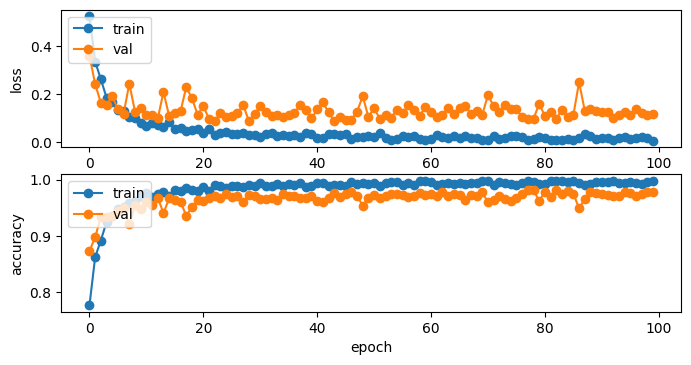

In [213]:
plt.figure(figsize=(8,4),dpi=100)

plt.subplot(2, 1, 1)
plt.plot(trace.history['loss'], '-o')
plt.plot(trace.history['val_loss'], '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(trace.history['categorical_accuracy'], '-o')
plt.plot(trace.history['val_categorical_accuracy'], '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

